In [1]:
import cv2
from pathlib import Path
import tensorflow as tf
from tensorflow import keras
from natsort import natsorted
import numpy as np
import pandas as pd

In [2]:
train=pd.read_csv('Training_set.csv')
train

,filename,label
0,Image_1.jpg,SOUTHERN DOGFACE
1,Image_2.jpg,ADONIS
2,Image_3.jpg,BROWN SIPROETA
3,Image_4.jpg,MONARCH
4,Image_5.jpg,GREEN CELLED CATTLEHEART
...,...,...
6494,Image_6495.jpg,MANGROVE SKIPPER
6495,Image_6496.jpg,MOURNING CLOAK
6496,Image_6497.jpg,APPOLLO
6497,Image_6498.jpg,ELBOWED PIERROT


In [3]:
train_dir=Path('train/')

In [4]:
train_images = natsorted(list(map(str, list(train_dir.glob("*.jpg")))))
len(train_images)

6499

In [5]:
train_labels=list(train['label'])
len(train_labels)

6499

In [6]:
target_class=list(set(label for label in train_labels))
len(target_class)

75

In [7]:
img_size=128
batch_size=10

In [8]:
from sklearn.preprocessing import LabelBinarizer
LB=LabelBinarizer()

In [9]:
train_labels=LB.fit_transform(train_labels)
train_labels.shape,LB.classes_.shape

((6499, 75), (75,))

In [10]:
def image_preprocessing(path):
    img=cv2.imread(path)
    img=cv2.GaussianBlur(img,(5,5),0)
    img=cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    clahe=cv2.createCLAHE(3,(16,16))
    img[:,:,0]=clahe.apply(img[:,:,0])
    img=cv2.cvtColor(img,cv2.COLOR_LAB2RGB)
    img=cv2.resize(img,(img_size,img_size))
    img=keras.layers.Rescaling(1./255)(img)
    img=img.numpy()
    return img

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
x_train,x_val,y_train,y_val=train_test_split(np.array(train_images),train_labels,test_size=0.2,random_state=42)

In [13]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape

((5199,), (5199, 75), (1300,), (1300, 75))

In [14]:
x_train=np.array(list(map(image_preprocessing,x_train)))
x_val=np.array(list(map(image_preprocessing,x_val)))

In [15]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train,y_train)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
validation_dataset = tf.data.Dataset.from_tensor_slices((x_val,y_val)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [16]:
import matplotlib.pyplot as plt

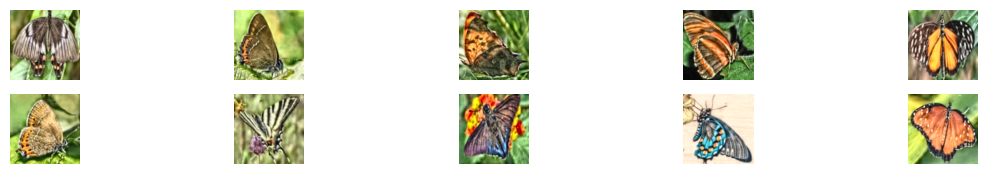

In [17]:
_, ax = plt.subplots(2, 5, figsize=(14, 2))
for batch in train_dataset.take(1):
    images = batch[0]
    for i in range(batch_size):
        img = images[i].numpy()
        ax[i//5,i%5].imshow(img)
        ax[i//5,i%5].axis("off")

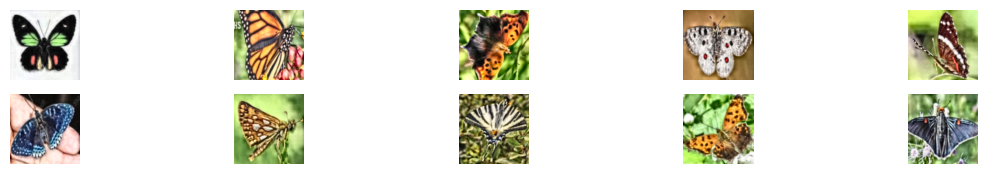

In [18]:
_, ax = plt.subplots(2, 5, figsize=(14, 2))
for batch in validation_dataset.take(1):
    images = batch[0]
    for i in range(batch_size):
        img = images[i].numpy()
        ax[i//5,i%5].imshow(img)
        ax[i//5,i%5].axis("off")

In [19]:
def build_model():
    input_img=keras.Input(shape=(img_size,img_size,3),name='image')

    base_model=keras.applications.MobileNet(include_top=False,
                                            weights='imagenet',
                                            input_tensor=input_img,
                                            input_shape=(img_size,img_size,3))
    base_model.trainable=False
    x=keras.layers.GlobalAveragePooling2D()(base_model.output)
    x=keras.layers.Dense(1000,'relu')(x)
    x=keras.layers.Dense(len(target_class),activation='softmax')(x)
    model=keras.models.Model(inputs=input_img,outputs=x)
    opt=keras.optimizers.Adam()
    model.compile(optimizer=opt,
                    loss=keras.losses.CategoricalCrossentropy(),
                    metrics=[keras.metrics.CategoricalAccuracy()])
    return model

In [20]:
model=build_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 128, 128, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 64, 64, 32)        864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 64, 64, 32)       128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 64, 64, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)       288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 64, 64, 32)       128       
 ation)                                                      

In [21]:
early_stop=keras.callbacks.EarlyStopping(monitor='val_loss',patience=10,restore_best_weights=True)
lr_scheduler=keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1, factor=0.5)

In [22]:
model.fit(train_dataset,
            validation_data=validation_dataset,
            epochs=100,
            callbacks=[early_stop,lr_scheduler])

Epoch 1/100
520/520 [==============================] - 9s 12ms/step - loss: 1.4543 - categorical_accuracy: 0.6422 - val_loss: 0.8031 - val_categorical_accuracy: 0.7615 - lr: 0.0010
Epoch 2/100
520/520 [==============================] - 5s 10ms/step - loss: 0.3410 - categorical_accuracy: 0.8990 - val_loss: 0.7935 - val_categorical_accuracy: 0.7977 - lr: 0.0010
Epoch 3/100
520/520 [==============================] - 5s 10ms/step - loss: 0.1483 - categorical_accuracy: 0.9594 - val_loss: 0.7441 - val_categorical_accuracy: 0.8062 - lr: 0.0010
Epoch 4/100
520/520 [==============================] - 5s 10ms/step - loss: 0.0981 - categorical_accuracy: 0.9694 - val_loss: 0.8724 - val_categorical_accuracy: 0.7900 - lr: 0.0010
Epoch 5/100
520/520 [==============================] - 5s 10ms/step - loss: 0.1132 - categorical_accuracy: 0.9656 - val_loss: 0.8395 - val_categorical_accuracy: 0.8123 - lr: 0.0010
Epoch 6/100
519/520 [============================>.] - ETA: 0s - loss: 0.1114 - categorical_acc

In [23]:
def unfreeze(model):
    for layer in model.layers:
        if not isinstance(layer, keras.layers.BatchNormalization):
            layer.trainable=True
    opt=keras.optimizers.Adam(1e-4,decay=0.1)
    model.compile(optimizer=opt,
                  loss=keras.losses.CategoricalCrossentropy(),
                  metrics=[keras.metrics.CategoricalAccuracy()])

In [24]:
unfreeze(model)

In [25]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 128, 128, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 64, 64, 32)        864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 64, 64, 32)       128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 64, 64, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)       288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 64, 64, 32)       128       
 ation)                                                      

In [26]:
history=model.fit(train_dataset,
            validation_data=validation_dataset,
            epochs=100,
            callbacks=[early_stop,lr_scheduler])

Epoch 1/100
520/520 [==============================] - 16s 27ms/step - loss: 0.0986 - categorical_accuracy: 0.9735 - val_loss: 0.5876 - val_categorical_accuracy: 0.8523 - lr: 1.0000e-04
Epoch 2/100
520/520 [==============================] - 13s 25ms/step - loss: 0.0103 - categorical_accuracy: 0.9994 - val_loss: 0.5905 - val_categorical_accuracy: 0.8562 - lr: 1.0000e-04
Epoch 3/100
520/520 [==============================] - 13s 25ms/step - loss: 0.0062 - categorical_accuracy: 0.9998 - val_loss: 0.5951 - val_categorical_accuracy: 0.8600 - lr: 1.0000e-04
Epoch 4/100
520/520 [==============================] - ETA: 0s - loss: 0.0047 - categorical_accuracy: 1.0000
Epoch 4: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
520/520 [==============================] - 13s 25ms/step - loss: 0.0047 - categorical_accuracy: 1.0000 - val_loss: 0.5980 - val_categorical_accuracy: 0.8623 - lr: 1.0000e-04
Epoch 5/100
520/520 [==============================] - 13s 25ms/step - loss: 0.0039

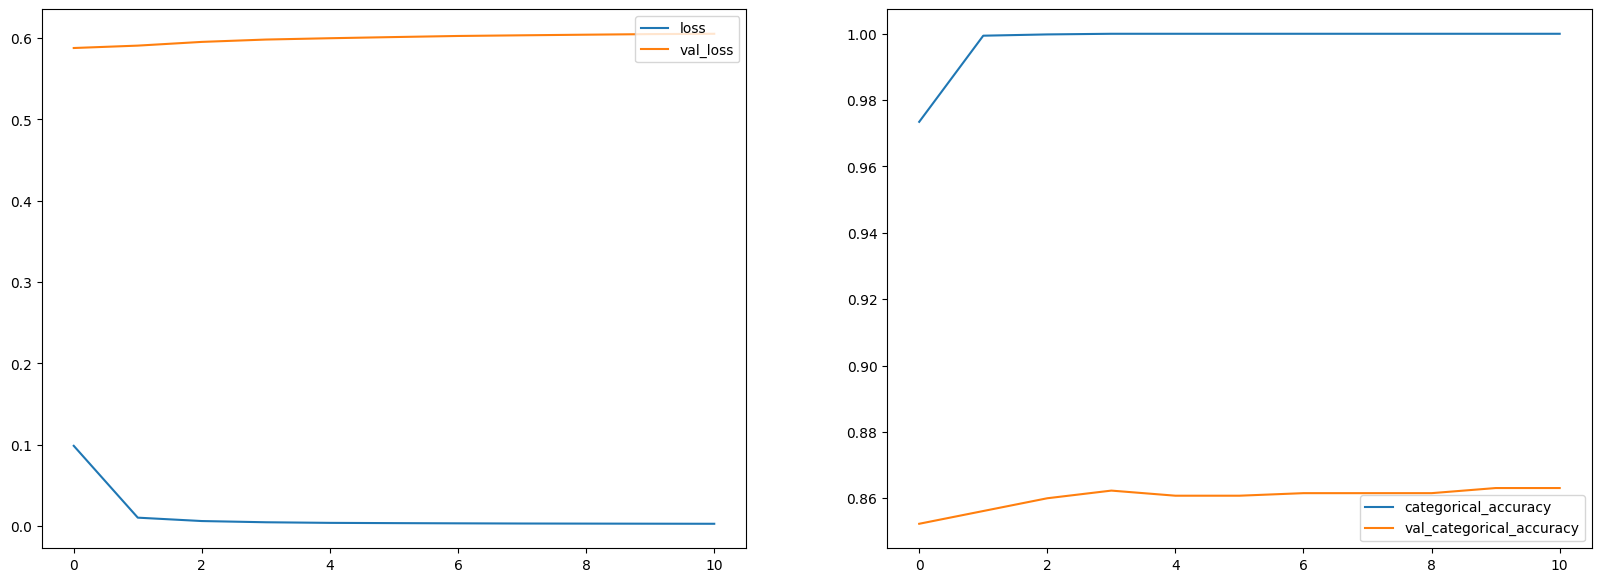

In [27]:
_, ax = plt.subplots(1, 2, figsize=(20,7))
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy=history.history['categorical_accuracy']
val_accuracy=history.history['val_categorical_accuracy']
epochs = range(len(loss))

ax[0].plot(epochs, loss)
ax[0].plot(epochs, val_loss)
ax[0].legend(['loss', 'val_loss'], loc='upper right')

ax[1].plot(epochs, accuracy)
ax[1].plot(epochs, val_accuracy)
ax[1].legend(['categorical_accuracy', 'val_categorical_accuracy'], loc='lower right')

In [28]:
y_pred=model.predict(validation_dataset)
y_pred=np.round(y_pred)

130/130 [==============================] - 1s 6ms/step


In [29]:
from sklearn.metrics import classification_report
print(classification_report(y_val,y_pred,target_names=LB.classes_))

                           precision    recall  f1-score   support

                   ADONIS       0.87      0.87      0.87        15
AFRICAN GIANT SWALLOWTAIL       1.00      0.95      0.97        19
           AMERICAN SNOOT       0.85      0.92      0.88        12
                    AN 88       1.00      1.00      1.00        10
                  APPOLLO       0.88      0.70      0.78        20
                    ATALA       0.94      0.94      0.94        17
 BANDED ORANGE HELICONIAN       1.00      0.89      0.94        19
           BANDED PEACOCK       0.93      0.87      0.90        15
            BECKERS WHITE       0.94      0.83      0.88        18
         BLACK HAIRSTREAK       1.00      0.89      0.94        18
              BLUE MORPHO       1.00      0.75      0.86        16
        BLUE SPOTTED CROW       1.00      0.92      0.96        12
           BROWN SIPROETA       0.88      0.81      0.84        26
            CABBAGE WHITE       0.94      0.94      0.94     

c:\Users\Habil\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [30]:
model.save('Butterfly_Classif.h5')